In [1]:
import os, sys
sys.path.append("../../common/")
from python_tools import *

In [2]:
@numba.jit
def costheta_numba(p1x,p1y,p1z,p1mag,
                   p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
                            (p1x*p2x+p1y*p2y+p1z*p2z)/p1mag/p2mag,
                            np.nan),
                   -1.0,1.0)

def eval_costheta(df,suffix1="",suffix2=""):
    return costheta_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,df.loc[:,"p"+suffix1].values,
                          df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values,df.loc[:,"p"+suffix2].values)

    
@numba.jit(nopython=True)
def q3_numba(p1x,p1y,p1z,p2x,p2y,p2z):
    return np.sqrt((p1x-p2x)**2+(p1y-p2y)**2+(p1z-p2z)**2)

def eval_q3(df,suffix1="",suffix2="_mu"):
    return q3_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,
                    df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values)

In [2]:
hdf5_filename = "/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.hdf5"
root_filename = "/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.root"
read_from_ROOT = False
write_to_hdf5 = False

if not os.path.isfile(hdf5_filename):
    read_from_ROOT = True
    write_to_hdf5 = True

In [3]:
p_df_1mu1p = pd.DataFrame()
p_df_1muNp = pd.DataFrame()
t_df = pd.DataFrame()
p_df = pd.DataFrame()

if read_from_ROOT:
    p_tree = uproot.open("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.root")['particle_tree']
    t_tree = uproot.open("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.root")['mctruth_tree']

    p_df = p_tree.pandas.df()
    p_df.set_index(["run","event","truth_index","p_index"],inplace=True)
    
    t_df = t_tree.pandas.df()
    t_df.set_index(["run","event","truth_index"],inplace=True)
    
    #p_df_grouped = p_df.query("status==1 or (status==0 and pdgcode==14)").groupby(["run","event","truth_index"],as_index=False)
    
    #p_df_1mu1p = p_df_grouped.filter(lambda x: filter_1muNp(x,thresh_mu=0.0,thresh_p=0.03,min_p_count=1,max_p_count=1))
    #p_df_1muNp = p_df_grouped.filter(lambda x: filter_1muNp(x,thresh_mu=0.0,thresh_p=0.03,min_p_count=0,max_p_count=999))

    if write_to_hdf5:
        #p_df_1mu1p.to_hdf("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.hdf5","p_df_1mu1p")
        #p_df_1muNp.to_hdf("/Users/wketchum/MicroBooNE_Data/genie_studies/genie_uboone_1M_simple.hdf5","p_df_1muNp")
        t_df.to_hdf(hdf5_filename,"t_df")
        p_df.to_hdf(hdf5_filename,"p_df")
else:
    t_df = pd.read_hdf(hdf5_filename,"t_df")
    p_df = pd.read_hdf(hdf5_filename,"p_df")
    #p_df_1muNp = pd.read_hdf(hdf5_filename,"p_df_1muNp")
    #p_df_1mu1p = pd.read_hdf(hdf5_filename,"p_df_1mu1p")

/Library/Python/2.7/site-packages/pandas/io/pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/Library/Python/2.7/site-packages/pandas/io/pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
/Library/Python/2.7/site-packages/pandas/io/pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
/Library/Python/2.7/site-packages/pandas/io/pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block2_items] [items->None]

%%time
count=1e6
for (_,_,_),group in p_df_grouped:
    #print group
    #print "\n\n"
    filter_1muNp_numba(group,thresh_mu=0.0,thresh_p=0.03,min_p_count=1,max_p_count=1)
    count = count-1
    if count==0: break

In [5]:
df_n = pd.DataFrame()
df_n["is_mu"] = ((p_df["status"]==1)&(p_df["pdgcode"]==13)).replace(False,np.nan)
df_n["is_p_30MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==2212)&((p_df["e"]-p_df["mass"])>0.03)).replace(False,np.nan)
df_n["is_pi"] = ((p_df["status"]==1)&((p_df["pdgcode"]==211)^(p_df["pdgcode"]==-211)^(p_df["pdgcode"]==111))).replace(False,np.nan)
df_n = df_n.groupby(["run","event","truth_index"]).agg("sum").rename(columns={"is_mu":"n_mu","is_p_30MeV":"n_p_30MeV","is_pi":"n_pi"})

In [6]:
p_df_p_grouped = p_df.query("status==1 and pdgcode==2212").sort_values(by=["e"],ascending=False).groupby(["run","event","truth_index"])
p_df_p1 = p_df_p_grouped.nth(0)
p_df_p2 = p_df_p_grouped.nth(1)
p_df_p3 = p_df_p_grouped.nth(2)

p_df_mu = p_df.query("status==1 and pdgcode==13").groupby(["run","event","truth_index"]).first()

p_df_nu = p_df.query("status==0 and pdgcode==14").groupby(["run","event","truth_index"]).first()

In [7]:
df_ev_t = t_df.copy()
df_ev_t = df_ev_t.merge(p_df_nu,how="left",on=["run","event","truth_index"],suffixes=["","_nu"])
df_ev_t = df_ev_t.merge(p_df_mu,how="left",on=["run","event","truth_index"],suffixes=["","_mu"])
df_ev_t = df_ev_t.merge(p_df_p1,how="left",on=["run","event","truth_index"],suffixes=["","_p1"])
df_ev_t = df_ev_t.merge(p_df_p2,how="left",on=["run","event","truth_index"],suffixes=["","_p2"])
df_ev_t = df_ev_t.merge(p_df_p3,how="left",on=["run","event","truth_index"],suffixes=["","_p3"])
df_ev_t = df_ev_t.merge(df_n,how="left",on=["run","event","truth_index"])

In [8]:
query_1mu1p = "n_mu==1 and n_p_30MeV==1 and n_pi==0"
query_1muNp = "n_mu==1 and n_pi==0"

cols_to_keep_1mu1p = [c for c in df_ev_t.columns if not (c.endswith("_p2") or c.endswith("_p3"))]
df_1mu1p = df_ev_t.query(query_1mu1p)[cols_to_keep_1mu1p].copy()
df_1muNp = df_ev_t.query(query_1muNp).copy()

In [9]:
df_1mu1p["costheta_mu"] = eval_costheta(df=df_1mu1p,suffix1="",suffix2="_mu")
df_1mu1p["costheta_p1"] = eval_costheta(df=df_1mu1p,suffix1="",suffix2="_p1")
df_1mu1p["q0"] = df_1mu1p["e"] - df_1mu1p["e_mu"]
df_1mu1p["q3"] = eval_q3(df=df_1mu1p,suffix1="",suffix2="_mu")

df_1muNp["costheta_mu"] = eval_costheta(df=df_1muNp,suffix1="",suffix2="_mu")
df_1muNp["costheta_p1"] = eval_costheta(df=df_1muNp,suffix1="",suffix2="_p1")
df_1muNp["q0"] = df_1muNp["e"] - df_1muNp["e_mu"]
df_1muNp["q3"] = eval_q3(df=df_1muNp,suffix1="",suffix2="_mu")

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


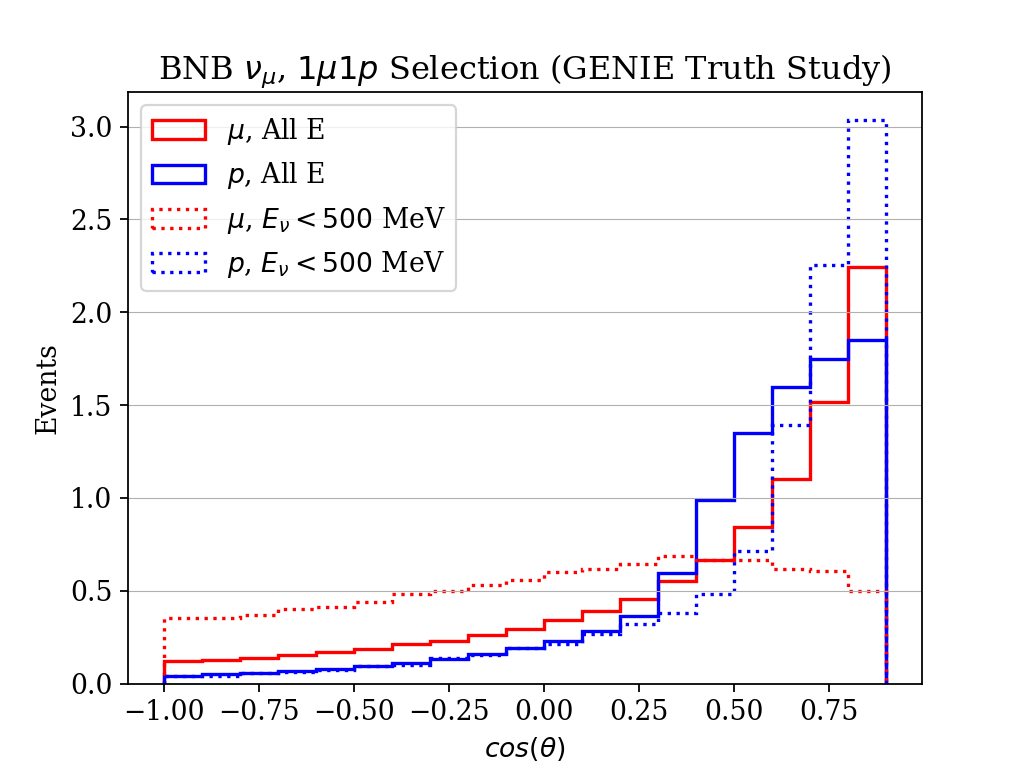

In [21]:
%matplotlib notebook

bins_theta = np.arange(-1.0,1.0,0.1)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1mu1p["costheta_mu"], color='red', label='$\mu$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p["costheta_p1"], color='blue', label='$p$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["costheta_mu"], color='red', label='$\mu$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["costheta_p1"], color='blue', label='$p$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.legend(loc=2)
plt.title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.xlabel("$cos(\\theta)$")
plt.ylabel("Events")
plt.show()
plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


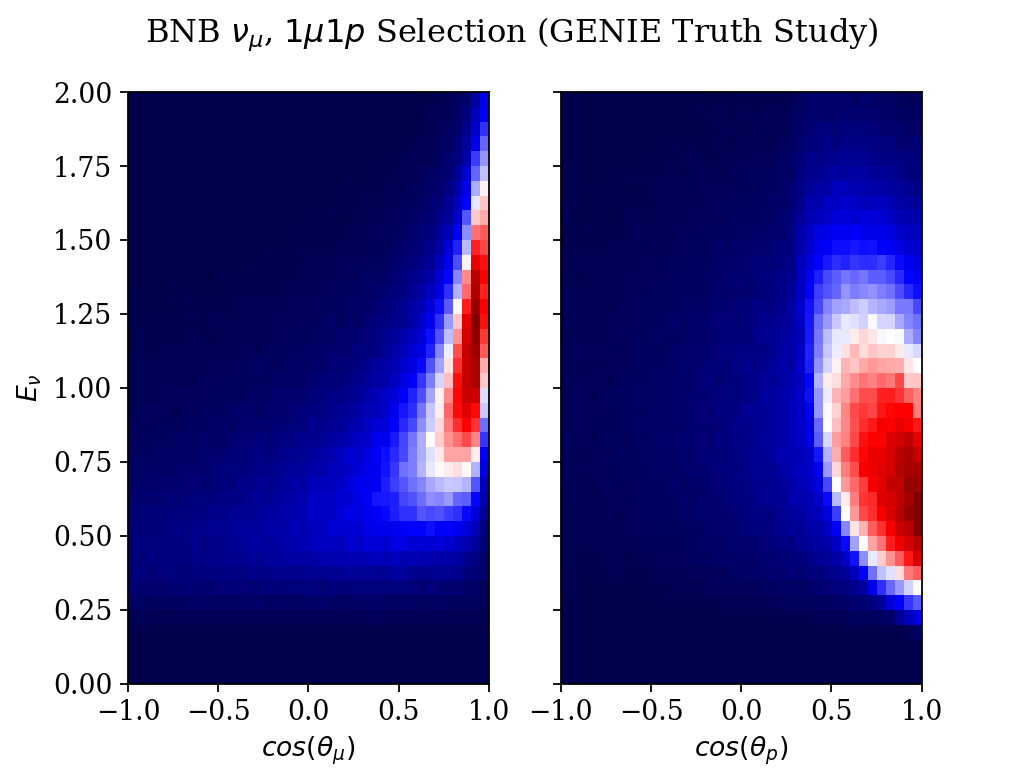

In [22]:
fig,axes = plt.subplots(1,2,sharex='all', sharey='all')

axes[0].hist2d(df_1mu1p["costheta_mu"],df_1mu1p["e"],bins=[40,40],range=[[-1,1],[0,2]])
axes[1].hist2d(df_1mu1p["costheta_p1"],df_1mu1p["e"],bins=[40,40],range=[[-1,1],[0,2]])
fig.suptitle("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[0].set_xlabel("$cos(\\theta_\mu)$")
axes[1].set_xlabel("$cos(\\theta_p)$")
axes[0].set_ylabel("$E_\\nu$")
plt.show()
plt.savefig("plots/genie_1mu1p_costheta_v_enu.pdf")

<IPython.core.display.Javascript object>


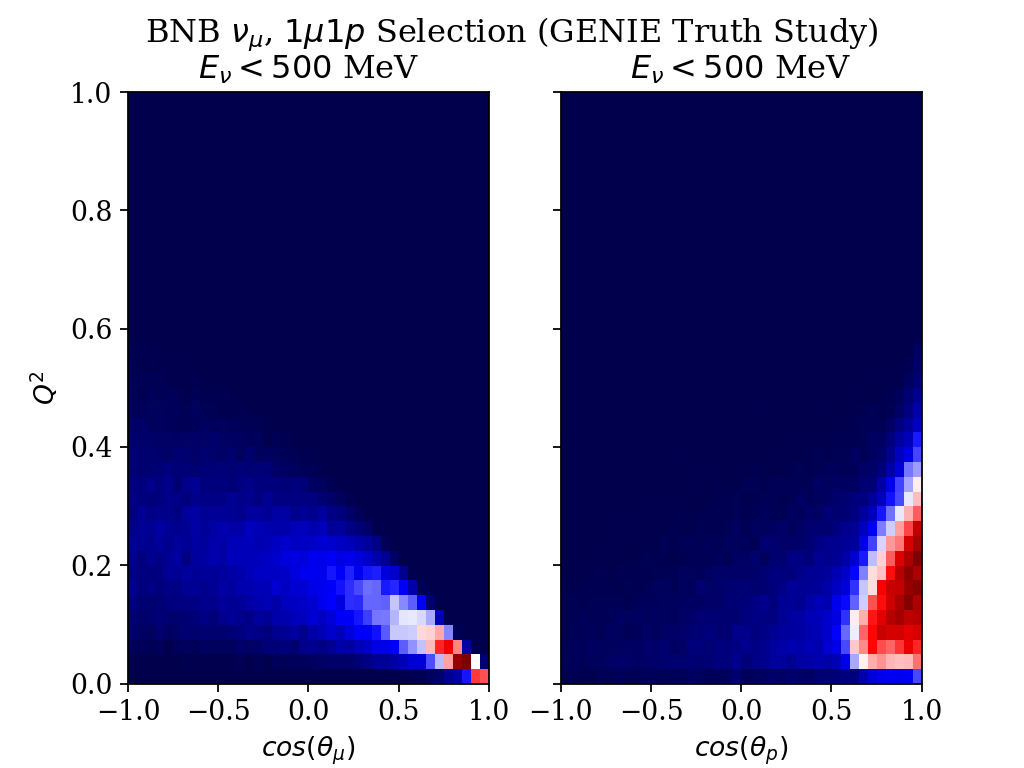

In [24]:
fig,axes = plt.subplots(1,2,sharex='all', sharey='all')

axes[0].hist2d(df_1mu1p.query("e<0.5")["costheta_mu"],df_1mu1p.query("e<0.5")["interaction_q2"],bins=[40,40],range=[[-1,1],[0,1]])
axes[1].hist2d(df_1mu1p.query("e<0.5")["costheta_p1"],df_1mu1p.query("e<0.5")["interaction_q2"],bins=[40,40],range=[[-1,1],[0,1]])
#axes[0].title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[0].set_xlabel("$cos(\\theta_\mu)$")
axes[1].set_xlabel("$cos(\\theta_p)$")
axes[0].set_ylabel("$Q^2$")
axes[0].set_title("$E_\\nu < 500$ MeV")
axes[1].set_title("$E_\\nu < 500$ MeV")
fig.suptitle("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.show()
plt.savefig("plots/genie_1mu1p_costheta_v_q2.pdf")

<IPython.core.display.Javascript object>


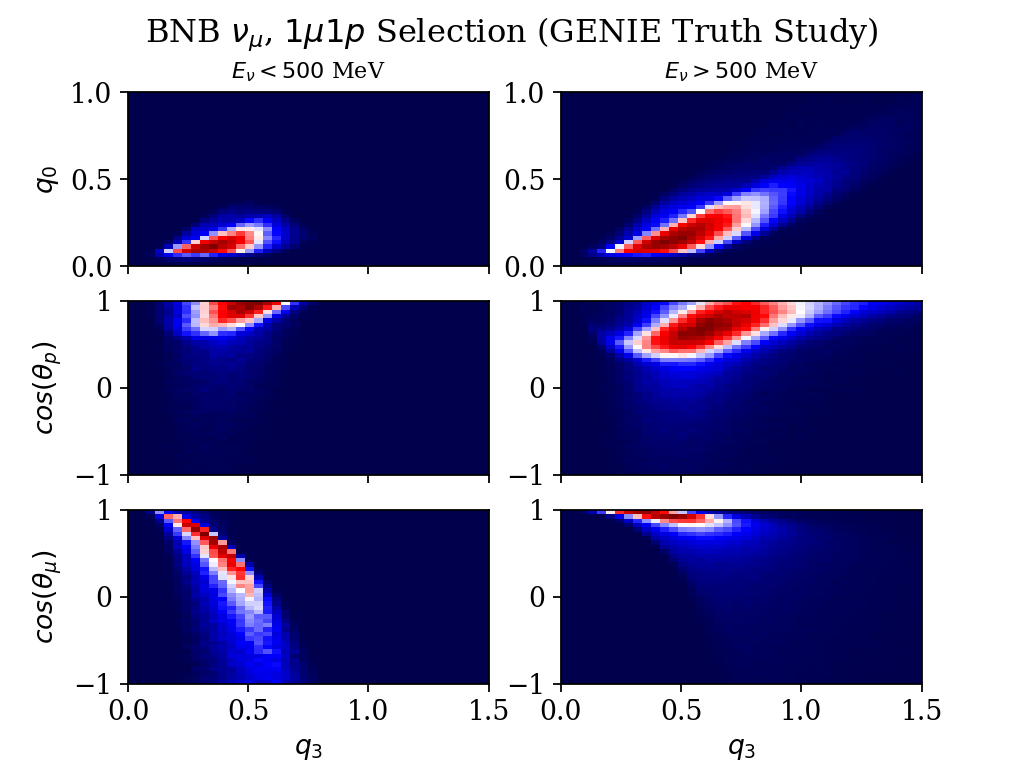

In [23]:
fig,axes = plt.subplots(3,2,sharex='all')

axes[0,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["q0"],bins=[40,40],range=[[0,1.5],[0,1.0]])
axes[0,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["q0"],bins=[40,40],range=[[0,1.5],[0,1.0]])
axes[1,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["costheta_p1"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[1,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["costheta_p1"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[2,0].hist2d(df_1mu1p.query("e<0.5")["q3"],df_1mu1p.query("e<0.5")["costheta_mu"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
axes[2,1].hist2d(df_1mu1p.query("e>0.5")["q3"],df_1mu1p.query("e>0.5")["costheta_mu"],bins=[40,40],range=[[0,1.5],[-1.0,1.0]])
#axes[0].title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
axes[2,0].set_xlabel("$q_3$")
axes[2,1].set_xlabel("$q_3$")
axes[0,0].set_ylabel("$q_0$")
axes[1,0].set_ylabel("$cos(\\theta_p)$")
axes[2,0].set_ylabel("$cos(\\theta_\mu)$")
axes[0,0].set_title("$E_\\nu < 500$ MeV",fontsize=10)
axes[0,1].set_title("$E_\\nu > 500$ MeV",fontsize=10)
fig.suptitle("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.show()
plt.savefig("plots/genie_1mu1p_kinematics_enu_hilo.pdf")

<IPython.core.display.Javascript object>


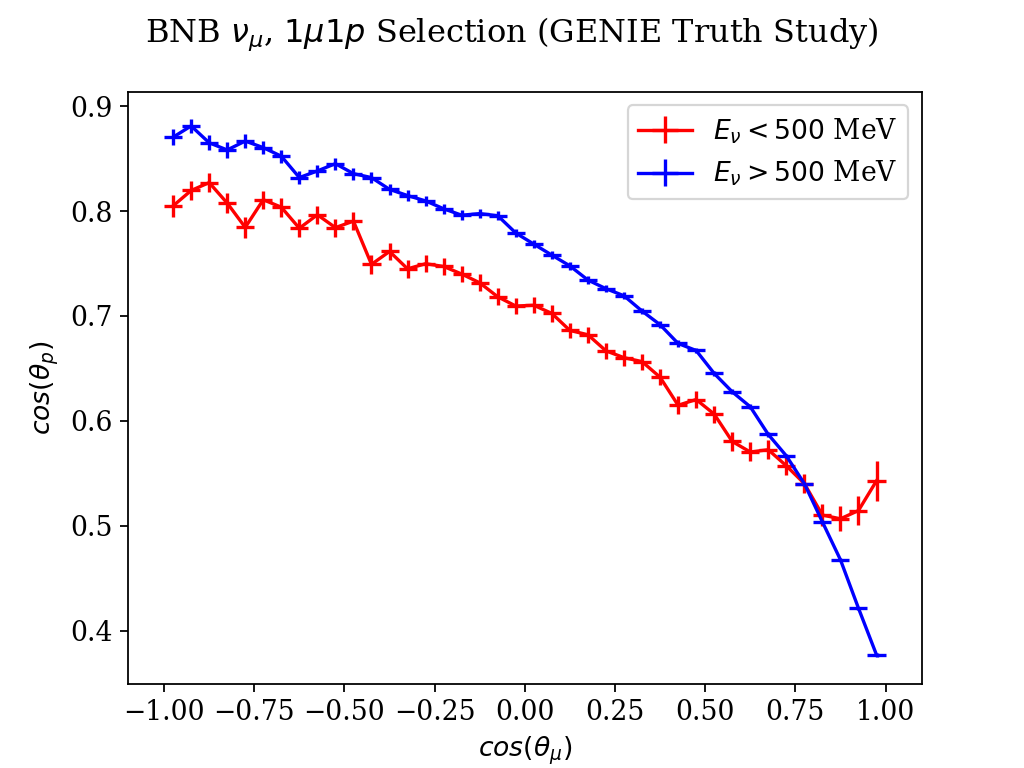

In [25]:
result_lowe=make_profile_bins(df=df_1mu1p.query("e<0.5"),
                              lowbin=-1.0,hibin=1.0,nbins=40,
                              xarg="costheta_mu",yarg="costheta_p1")
result_hie=make_profile_bins(df=df_1mu1p.query("e>0.5"),
                             lowbin=-1.0,hibin=1.0,nbins=40,
                             xarg="costheta_mu",yarg="costheta_p1")
fig,axes = plt.subplots()

plt.errorbar(x=result_lowe['x'],
             y=result_lowe['y'],
             xerr=result_lowe['xerr'],
             yerr=result_lowe['yerr'],
             linestyle='-',color='red',label='$E_\\nu < 500$ MeV')
plt.errorbar(x=result_hie['x'],
             y=result_hie['y'],
             xerr=result_hie['xerr'],
             yerr=result_hie['yerr'],
             linestyle='-',color='blue',label='$E_\\nu > 500$ MeV')
plt.xlabel("$cos(\\theta_\mu)$")
plt.ylabel("$cos(\\theta_p)$")
plt.legend()
fig.suptitle("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.show()
plt.savefig("plots/genie_1mu1p_costheta_prof.pdf")

<IPython.core.display.Javascript object>


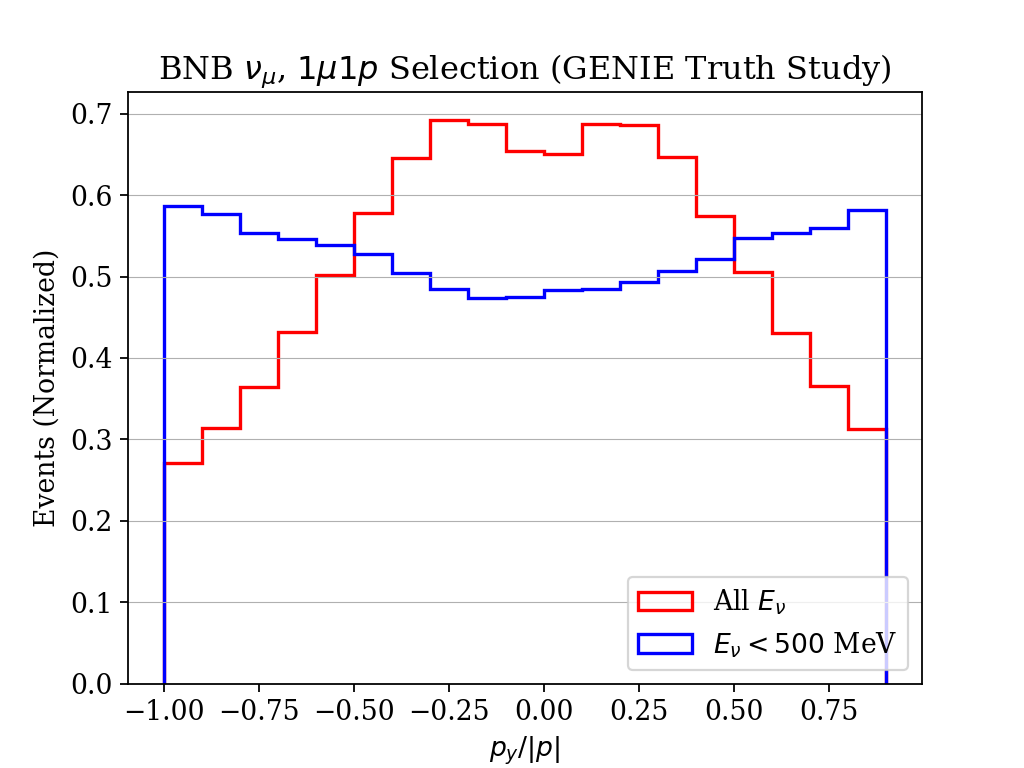

In [26]:
fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1mu1p["py_mu"]/df_1mu1p["p_mu"], color='red', label='All $E_\\nu$',bins=np.arange(-1.,1.,0.1), density=True, **pltops_hist)
plt.hist(df_1mu1p.query("e<0.5")["py_mu"]/df_1mu1p.query("e<0.5")["p_mu"], color='blue', label='$E_\\nu < 500$ MeV', bins=np.arange(-1.,1.,0.1), density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu$, $1\mu1p$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()
plt.savefig("plots/genie_1mu1p_py_p.pdf")

<IPython.core.display.Javascript object>


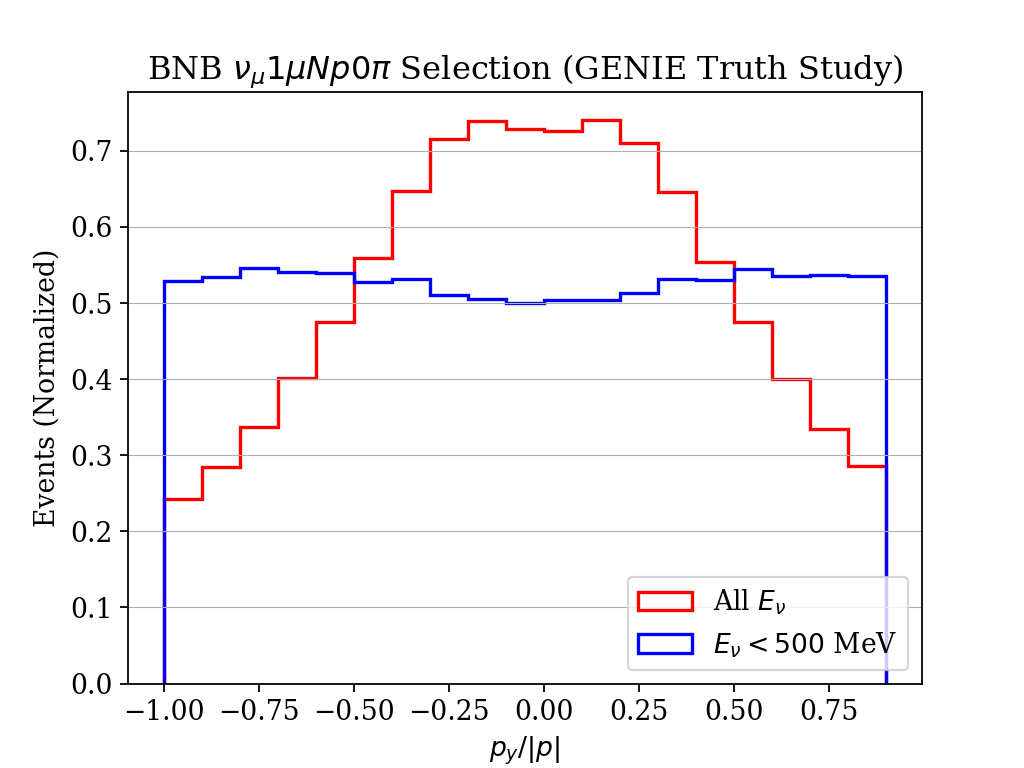

In [27]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.1)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["py_mu"]/df_1muNp["p_mu"], color='red', label='All $E_\\nu$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["py_mu"]/df_1muNp.query("e<0.5")["p_mu"], color='blue', label='$E_\\nu < 500$ MeV', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()
plt.savefig("plots/genie_1muNp_py_p.pdf")

<IPython.core.display.Javascript object>


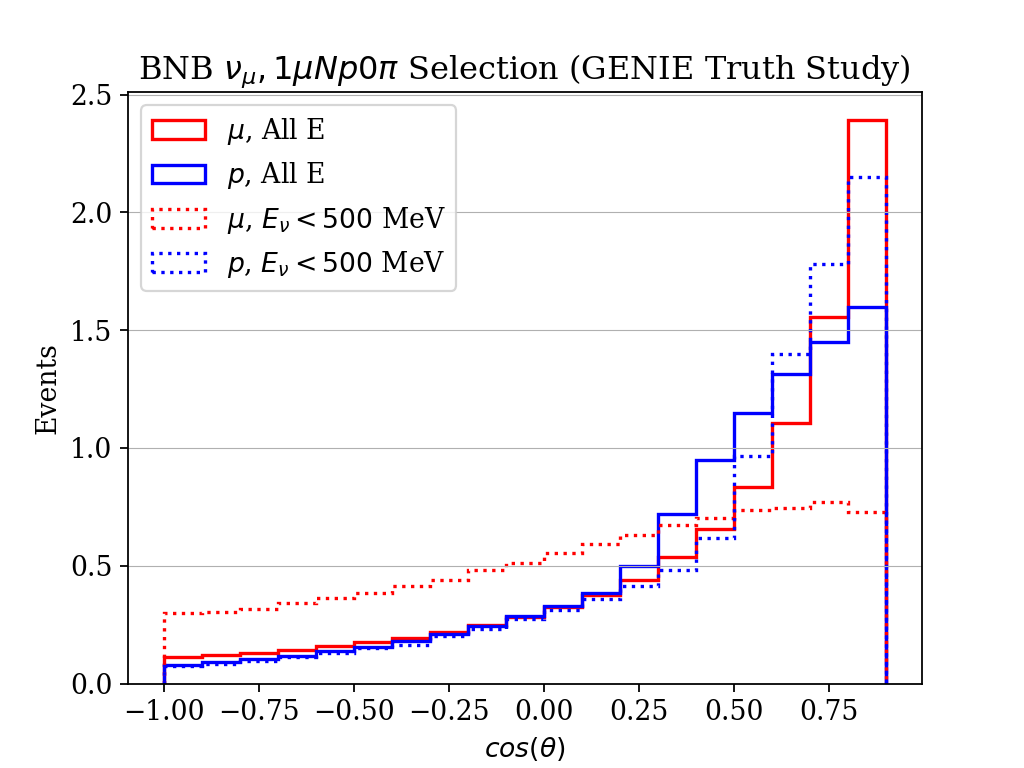

In [17]:
%matplotlib notebook

bins_theta = np.arange(-1.0,1.0,0.1)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["costheta_mu"], color='red', label='$\mu$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1muNp["costheta_p1"], color='blue', label='$p$, All E', bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["costheta_mu"], color='red', label='$\mu$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["costheta_p1"], color='blue', label='$p$, $E_\\nu<500$ MeV', linestyle=":", bins=bins_theta, density=True,**pltops_hist)
plt.legend(loc=2)
plt.title("BNB $\\nu_\mu, 1\mu N p 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$cos(\\theta)$")
plt.ylabel("Events")
plt.show()
plt.savefig("plots/genie_1muNp_costheta.pdf")

<IPython.core.display.Javascript object>


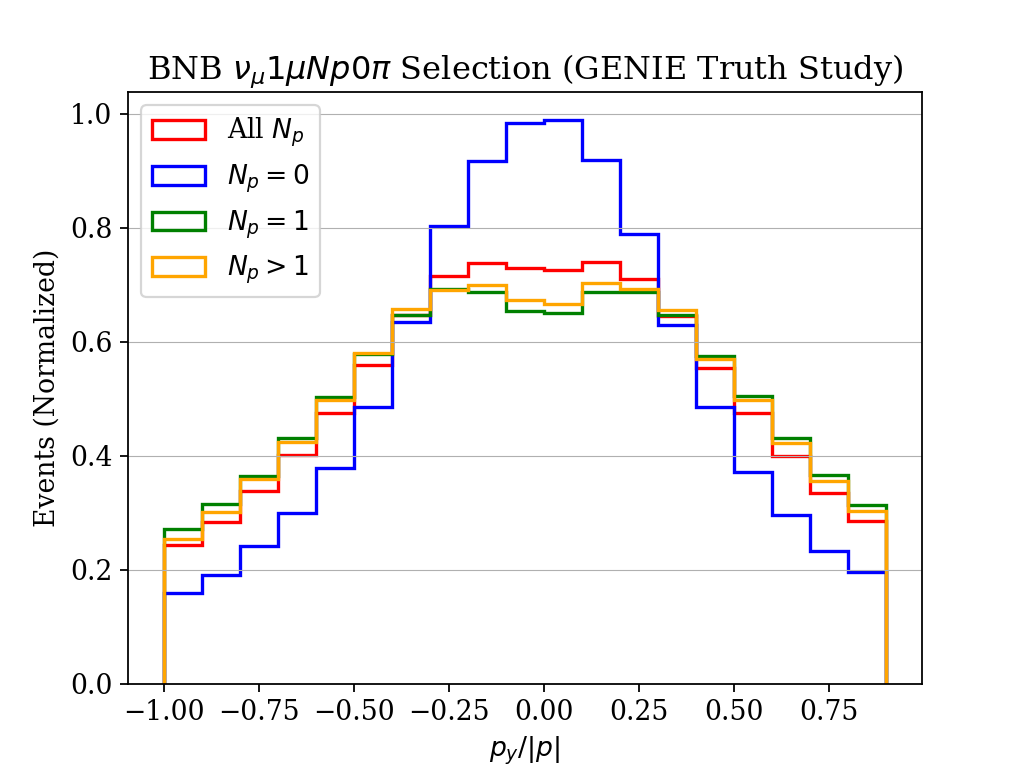

In [18]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.1)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["py_mu"]/df_1muNp["p_mu"], color='red', label='All $N_p$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV==0")["py_mu"]/df_1muNp.query("n_p_30MeV==0")["p_mu"], color='blue', label='$N_p=0$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV==1")["py_mu"]/df_1muNp.query("n_p_30MeV==1")["p_mu"], color='green', label='$N_p=1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV>1")["py_mu"]/df_1muNp.query("n_p_30MeV>1")["p_mu"], color='orange', label='$N_p>1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=2)
plt.show()
plt.savefig("plots/genie_1muNp_py_p_np.pdf")

<IPython.core.display.Javascript object>


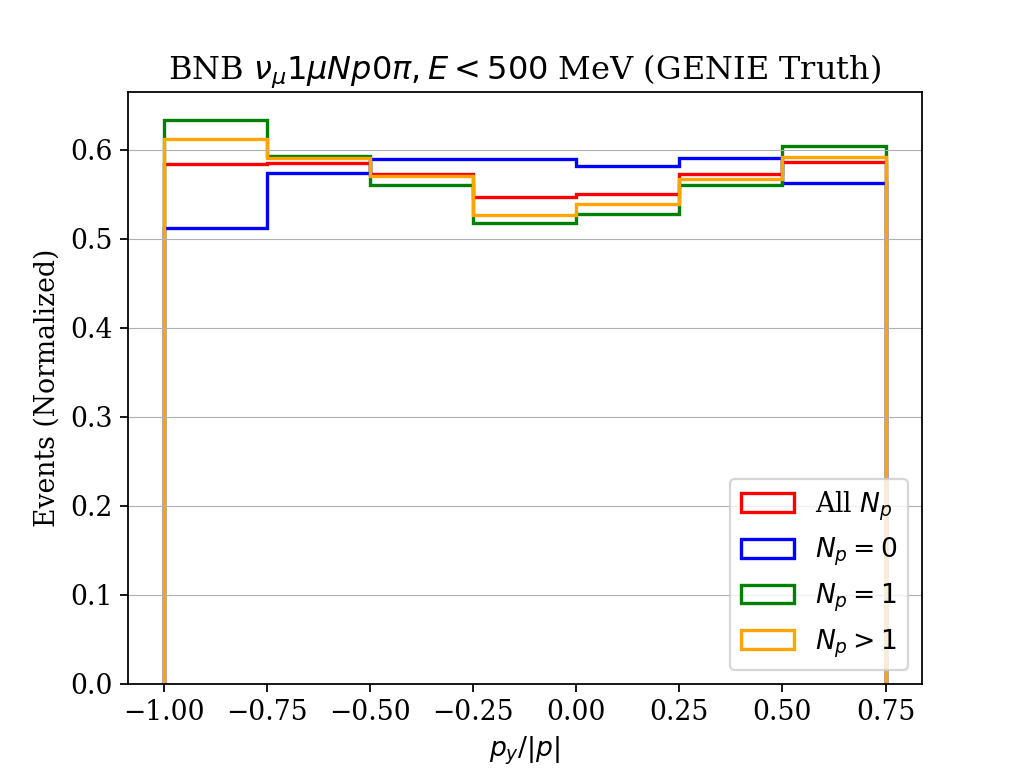

In [19]:
fig,ax = plt.subplots()

bins_py_ratio=np.arange(-1.,1.,0.25)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp.query("e<0.5")["py_mu"]/df_1muNp.query("e<0.5")["p_mu"], color='red', label='All $N_p$',bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV==0 and e<0.5")["py_mu"]/df_1muNp.query("n_p_30MeV==0 and e<0.5")["p_mu"], color='blue', label='$N_p=0$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV==1 and e<0.5")["py_mu"]/df_1muNp.query("n_p_30MeV==1 and e<0.5")["p_mu"], color='green', label='$N_p=1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.hist(df_1muNp.query("n_p_30MeV>1 and e<0.5")["py_mu"]/df_1muNp.query("n_p_30MeV>1 and e<0.5")["p_mu"], color='orange', label='$N_p>1$', bins=bins_py_ratio, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi, E<500$ MeV (GENIE Truth)")
plt.xlabel("$p_y / |p|$")
plt.ylabel("Events (Normalized)")
plt.legend(loc=4)
plt.show()
plt.savefig("plots/genie_1muNp_py_p_np_lowenu.pdf")

<IPython.core.display.Javascript object>


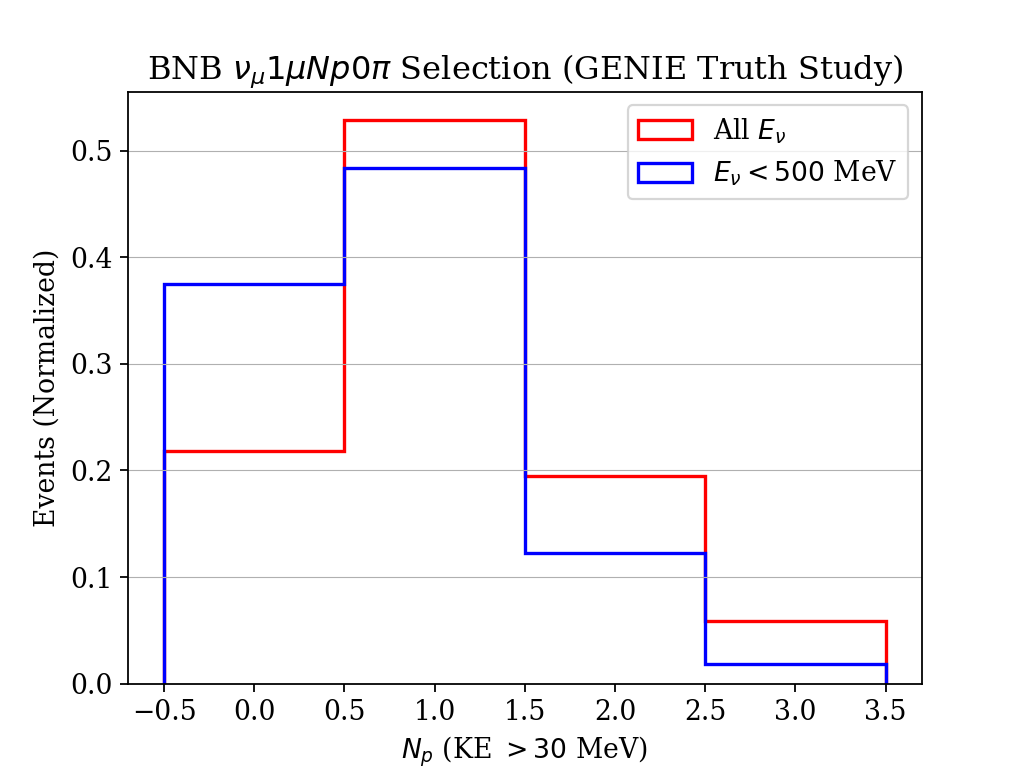

In [20]:
fig,ax = plt.subplots()

bins_np=np.arange(-0.5,4.5,1.0)

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_1muNp["n_p_30MeV"], color='red', label='All $E_\\nu$',bins=bins_np, density=True, **pltops_hist)
plt.hist(df_1muNp.query("e<0.5")["n_p_30MeV"], color='blue', label='$E_\\nu < 500$ MeV', bins=bins_np, density=True, **pltops_hist)
plt.title("BNB $\\nu_\mu 1\mu Np 0\pi$ Selection (GENIE Truth Study)")
plt.xlabel("$N_p$ (KE $>30$ MeV)")
plt.ylabel("Events (Normalized)")
plt.legend(loc=1)
plt.show()
plt.savefig("plots/genie_1muNp_np.pdf")